In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.opto_stim_import import merge_sessions
from utils.opto_stim_import import opto_stim_import
import seaborn as sns
import pandas as pd
from scipy import stats
from utils.d_prime import d_prime
import matplotlib.patches as mpatches
from scipy.optimize import curve_fit

sns.set(style='white', font_scale=1.8)
sns.set_palette("colorblind")

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
LUT_path = os.path.expanduser(r'~/Desktop/behaviour/behavioural_LUT.csv')
behaviour_path = os.path.expanduser(r'~/Desktop/behaviour')
figure_path = os.path.expanduser(r'~/Desktop/behaviour_figures')


In [3]:
c1v1_list = ['CBCB1213.1b', 'CBCB1177.4b', 'CBCB1177.4c']
stc_list = ['J009', 'J011', 'J013']

In [4]:
%%capture
#parse useful information from txt files using opto_stim_import.py classes

#list of number of trials it took each c1v1 mouse to get out of auto phase
c_autoswitch = []
c_LED_current = []

for cID in c1v1_list:
    sessions = merge_sessions(cID, behaviour_path, LUT_path)
    c_autoswitch.append(sessions.trial_autoswitch)
c_autoswitch = np.array(c_autoswitch)
    
#list of number of trials it took each st-chrome mouse to get out of auto phase
s_autoswitch = []
for sID in stc_list:
    sessions = merge_sessions(sID, behaviour_path, LUT_path)
    s_autoswitch.append(sessions.trial_autoswitch)
s_autoswitch = np.array(s_autoswitch)
    
auto_data = pd.DataFrame({'opsin activated': c_autoswitch, 'controls': s_autoswitch})

In [5]:
#make individual points plottable

x_opsin = [0] * len(c_autoswitch)
y_opsin = c_autoswitch

x_controls = [1] * len(s_autoswitch)
y_controls = s_autoswitch

y_opsin

array([18, 14,  7])

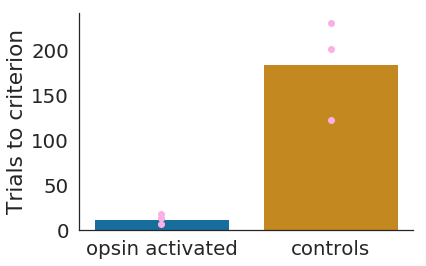

In [6]:
fig =sns.barplot(data=auto_data, order=['opsin activated', 'controls'],ci=None)
sns.despine()
fig.set(ylabel='Trials to criterion')

plt.plot(x_opsin, y_opsin, 'o', color=sns.color_palette()[6], markersize = 6)
plt.plot(x_controls, y_controls, 'o', color=sns.color_palette()[6], markersize =6)
plt.savefig(os.path.join(figure_path, 'auto_tranisition.svg'))
plt.savefig(os.path.join(figure_path, 'auto_tranisition.png'))

In [7]:
# test the above plot for statistical significance 
stats.ttest_ind(c_autoswitch, s_autoswitch)

Ttest_indResult(statistic=-5.346052765584511, pvalue=0.0059012526406468065)

In [8]:
def calc_dprime(outcome):
    '''takes input of outcome array and uses matthias dprime function  '''
    num_hits = len(np.where(outcome=='hit')[0])
    num_miss = len(np.where(outcome=='miss')[0])
    num_fa = len(np.where(outcome=='fa')[0])
    num_cr = len(np.where(outcome=='cr')[0])
    
    hit_rate = num_hits / (num_hits + num_miss)
    false_alarm_rate = num_fa / (num_fa + num_cr)
    
    return hit_rate, d_prime(hit_rate, false_alarm_rate)

In [9]:
def dprime_powers(mice, LUT, c1=None, c2=None):

    '''
    get dprimes at different powers. Takes input:
       mice - list of mice
       LUT - LUT path
       c1 - current list 1
       c2 - current list 2
       
       if no currents are given, returns d-prime across all power levels (this is currently in hack form)
       
       returns:
       3d array of dprimes (n_mice x n_powers)

    '''
    #hack
    if c1:
        num_powers = len(c1)
    else:
        num_powers = 1

    #nested list of each mouse and dprimes at each power
    power_dprimes=[]
    for ID in mice:
        sessions = merge_sessions(ID, behaviour_path, LUT)
        LED_current = np.array(sessions.LED_current)
        outcome = np.array(sessions.outcome)

        #dprime at each power for an indvidual mouse
        mouse_dprimes = []

        #hitrate at each power for an indidual mouse
        mouse_hitrate = []

        for p in range(num_powers):
            if c1:
                #index of the trial number using this power
                power_ind = np.where((LED_current == c1[p]) | (LED_current == c2[p]))[0]
                #power is not printed on the first trial, so shift back 1
                power_ind = np.array(power_ind) - 1
            else:
                power_ind = range(len(LED_current))
            
            
            power_outcome = outcome[power_ind]

            assert len(power_ind) == len(power_outcome)
            
            try:
                hit_rate, dprime = calc_dprime(power_outcome)
            except ZeroDivisionError:
                dprime = np.nan
                hit_rate = np.nan
                

            mouse_hitrate.append(hit_rate)
            mouse_dprimes.append(dprime)

        plt.plot(mouse_dprimes)
        power_dprimes.append(mouse_dprimes)

    #create 3d array from nested list
    power_dprimes = np.vstack(power_dprimes)

    return power_dprimes

In [10]:
%%capture

# lists of currents used to run opto_stim tasks
# improve this in future, make dictionary / LUT with currents used for given LED output powers
c1 = [64.73, 32.43, 13.05, 6.59, 3.36, 1.42, 0.78]
c2 = [53.73, 27.36, 11.53, 6.26, 3.62, 2.04, 1.51]

# the LED output power these currents generate
full_LED_power = [10,5,2,1,0.5,0.2,0.1]

power_dprimes = dprime_powers(c1v1_list, LUT_path, c1, c2)

#calculate the mean, removing the highest power as this is when the mouse initially learns the task
# also remove lowest power as this is found in psychometric test (and i can't be bothered to average them)
mean_pdp = np.mean(power_dprimes,0)
mean_pdp = mean_pdp[1:-1]

#match up the trimming of the LED power
LED_power = full_LED_power[1:-1]

In [11]:
%%capture
# same again for the psychometric condition
LUT_path_pm = os.path.expanduser('/home/jamesrowland/Desktop/behaviour/behavioural_LUT_psychometric.csv')
pm_c1 = [0.78, 0.65, 0.52, 0.39, 0.26]
pm_c2 = [0.85, 0.7, 0.56, 0.41, 0.27]

LED_power_pm = [0.1,0.08,0.06,0.04,0.02]

power_dprimes_pm = dprime_powers(['CBCB1213.1b', 'J008', 'J006'], LUT_path_pm, pm_c1, pm_c2)

mean_pdp_pm = np.mean(power_dprimes_pm,0)

In [12]:


%%capture

# get dprime across all trials (excluding psychometric) for c1v1 and controls
grand_dprimes_stc = dprime_powers(stc_list, LUT_path,c1,c2)
grand_dprimes_c1v1 = dprime_powers(c1v1_list, LUT_path,c1,c2)

#current plots show std have not yet implemented std
# grand_stc_err = np.nanstd(power_dprimes_stc) ** 2
# grand_c1v1_err = np.nanstd(power_dprimes) ** 2

In [13]:
#make inididual points for plot
x_opsin = [0] * len(grand_dprimes_c1v1.ravel())
y_opsin = grand_dprimes_c1v1.ravel()

x_controls = [1] * len(grand_dprimes_stc.ravel())
y_controls = grand_dprimes_stc.ravel()

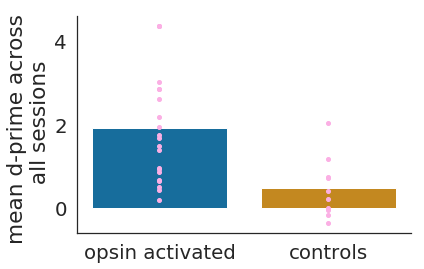

In [14]:
grand_data = pd.DataFrame({'opsin activated': grand_dprimes_c1v1.ravel(), 'controls': grand_dprimes_stc.ravel()})
fig =sns.barplot(data=grand_data, order=['opsin activated', 'controls'],ci=None)
plt.plot(x_opsin, y_opsin, 'o', color=sns.color_palette()[6], markersize=4)
plt.plot(x_controls, y_controls, 'o', color=sns.color_palette()[6], markersize=4)
sns.despine()
fig.set(ylabel='mean d-prime across \n all sessions')
plt.savefig(os.path.join(figure_path, 'dprime_grand.svg'))
plt.savefig(os.path.join(figure_path, 'dprime_grand.png'))

In [15]:
# logarithmic function
def log_fit(x, p1,p2):
      return p1*np.log(x)+p2

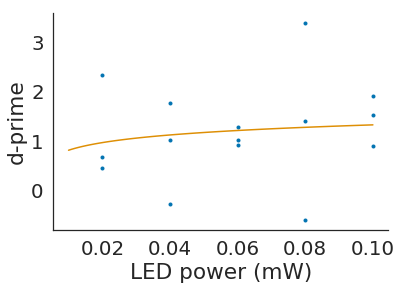

In [29]:
LED_powers = LED_power_pm
LED_powers = np.flip(LED_powers,0)
plt.figure()
for mouse_pm in power_dprimes_pm:
    #plot the raw data
    plt.plot(LED_powers, mouse_pm, '.', color=sns.color_palette()[0])

    
    

mean_power_dp = np.mean(power_dprimes_pm,0)

popt, pcov = curve_fit(log_fit, LED_powers, mean_power_dp, p0=(1.0,10.2))

# curve params
p1 = popt[0]
p2 = popt[1]

# plot curve
x_fit = np.linspace(pow(10,-2), pow(10,-1), num=100)
y_fit = log_fit(x_fit,p1,p2)


plt.plot(x_fit,y_fit, color=sns.color_palette()[1])


#plt.xscale('log')
#plt.xticks([pow(10,-2), pow(10,-1), 1, pow(10,1)])
sns.despine()
plt.xlabel('LED power (mW)')
plt.ylabel('d-prime')

plt.savefig(os.path.join(figure_path, 'dprime_power.svg'))
plt.savefig(os.path.join(figure_path, 'dprime_power.png'))


In [17]:
power_dprimes_pm.shape


np.mean(power_dprimes_pm,0).shape

(5,)

In [18]:
def plot_steps(mouse_list, color_ind, c1, c2, LED_power):
    '''builds a steps plot for a list of mice'''
    num_powers = len(c1)
    for ID in mouse_list:
        sessions = merge_sessions(ID, behaviour_path, LUT_path)
        #the trial number where a switch occured
        LED_current = np.array(sessions.LED_current)

        #an array showing the power at each trial
        trial_power = []
        for p in range(num_powers):
            power_ind = np.where((LED_current == c1[p]) | (LED_current == c2[p]))[0]
            #the number of steps required to get off this power
            n_trials_step = len(power_ind)

            [trial_power.append(LED_power[p]) for x in range(n_trials_step)]


        plt.plot(trial_power,c=sns.color_palette()[color_ind])

Importing data file: CBCB1213.1b-2018-10-15-194755.txt
258 trials total
Importing data file: CBCB1213.1b-2018-10-16-120105.txt
191 trials total
Importing data file: CBCB1213.1b-2018-10-17-122753.txt
128 trials total
Across sessions, mouse CBCB1213.1b has done 577 trials
Importing data file: CBCB1177.4b-2018-10-16-175014.txt
135 trials total
Importing data file: CBCB1177.4b-2018-10-16-182329.txt
92 trials total
Importing data file: CBCB1177.4b-2018-10-17-164109.txt
146 trials total
Across sessions, mouse CBCB1177.4b has done 373 trials
Importing data file: CBCB1177.4c-2018-10-16-191025.txt
172 trials total
Importing data file: CBCB1177.4c-2018-10-17-152721.txt
90 trials total
Across sessions, mouse CBCB1177.4c has done 262 trials
Importing data file: J009-2018-11-20-120014.txt
180 trials total
Importing data file: J009-2018-11-21-170029.txt
169 trials total
Importing data file: J009-2018-11-22-172640.txt
220 trials total
Importing data file: J009-2018-11-23-164834.txt
284 trials total
A

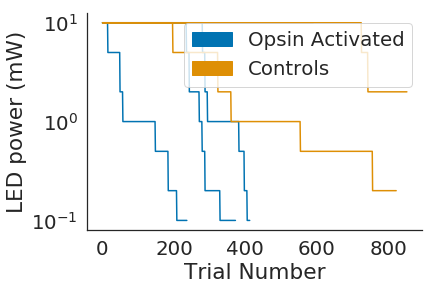

In [19]:
plt.figure
plot_steps(c1v1_list,0,c1,c2, full_LED_power)
plot_steps(stc_list,1,c1,c2, full_LED_power)
sns.despine()
plt.xlabel('Trial Number')
plt.ylabel('LED power (mW)')
plt.yscale('log')
opsin_label = mpatches.Patch(color=sns.color_palette()[0], label='Opsin Activated')
control_label = mpatches.Patch(color=sns.color_palette()[1], label='Controls')
plt.legend(handles=[opsin_label, control_label], loc='upper right')

plt.savefig(os.path.join(figure_path, 'power_steps.svg'))
plt.savefig(os.path.join(figure_path, 'power_steps.png'))

In [20]:
def reaction_time(mice, trial_type='hit'):
## get reaction time for go trials
    react_times = []
    for ID in mice:
        sessions = merge_sessions(ID, behaviour_path, LUT_path)
        binned_licks = np.array(sessions.binned_licks)
        outcome = np.array(sessions.outcome)
        autorewarded_trial = np.array(sessions.autorewarded_trial)
        
        if trial_type == 'hit':
            trial_ind = np.where((outcome=='hit'))[0]
        elif trial_type == 'autoreward':
            trial_ind = np.where(autorewarded_trial == True)[0]
        else:
            raise ValueError('unknown trial type')

        react_time = []
        for b in binned_licks[trial_ind]:

            react_time.append(b[0])


        react_times.append(react_time)
    return react_times
        

In [21]:
session = opto_stim_import('CBCB1213.1b', behaviour_path, '2018-10-17', 'CBCB1213.1b-2018-10-17-122753')

#licks are binned and normalised to trial start time (5ms before LED pulse)
binned_licks = np.array(session.binned_licks)

trial_type = np.array(session.trial_type)
tt_inds = trial_type.argsort()

sorted_licks = binned_licks[tt_inds]

num_go = len(np.where(trial_type=='go')[0])


Importing data file: CBCB1213.1b-2018-10-17-122753.txt
128 trials total


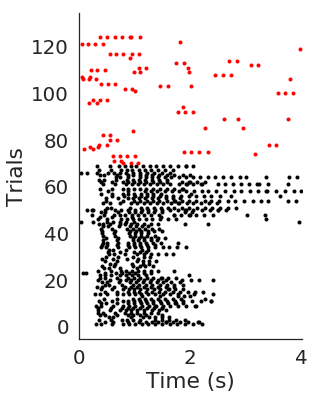

In [22]:
plt.figure(figsize=[4,6])


for i,b in enumerate(sorted_licks):
    y_axis = np.ones(len(b)) + (i) 
    if i < num_go:
        color = 'black'
    else:
        color = 'red'
    plt.plot(b/1000, y_axis,'.',c=color)
    
plt.xlim((0,4))
sns.despine()
plt.xlabel('Time (s)')
plt.ylabel('Trials')
plt.savefig(os.path.join(figure_path, 'lick_raster.png'))
plt.savefig(os.path.join(figure_path, 'lick_raster.svg'))








